# Data exploration and CO2 prediction model (supervised)

Import the necessary libraries:

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import dask.dataframe as dd
import pandas as pd
import altair as alt
from tqdm import tqdm
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.base import clone
#from raiwidgets import ResponsibleAIDashboard
#from responsibleai import RAIInsights
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import shap
import itertools
from collections.abc import Iterable
from scipy.stats import norm
import dill

ModuleNotFoundError: No module named 'shap'

## Data import and exploration

WARNING! IF WE ALREADY HAVE THE FINAL PARQUET FILE SAVED, WE CAN SKIP ALL THIS AND JUST RUN THE CELL LOADING 'final_data.parquet'

We are going to start loading our data from the csv files for every year. As the dataset is too big to fit in memory, we will use dask to import it.

In [ ]:
#Specify data types to avoid importing errors when concatenating different years

dtypes = {'ID': str, 'VFN': str, 'Mp': str, 'Mh': str, 'Man': str, 'MMS': str, 
          'Tan': str, 'T': str, 'Va': str, 'Ve': str, 'Mk': str, 'Cn': str, 'Ct': str, 
          'Cr':str, 'r': float, 'm (kg)': float, 'Mt': float, 'Enedc (g/km)': float, 
          'Ewlpt (g/km)': float, 'W (mm)': float, 'At1 (mm)':float, 'At2 (mm)': float, 
          'Ft': str, 'Fm': str, 'ec (cm3)': float, 'ep (KW)': float, 'z (Wh/km)': float, 
          'IT': str, 'Ernedc (g/km)': float, 'Erwltp (g/km)': float, 'De': float, 'Vf': float, 
          'Status': str, 'year':int, 'Date of registration': str, 'Fuel consumption': float, 
          'Electric range (km)': float}

#Read all csvs in a dask dataframe
df = dd.read_csv('data//data_*.csv', dtype=dtypes)

#Save the entire dataframe to parquet
df.to_parquet('data/data.parquet')

After importing, we are going to remove the duplicates:

In [ ]:
#Create a new dataframe without duplicates (skip ID which is unique to every row)
udf_nc = df.drop_duplicates(subset=df.columns[1:])
#Repartition to upload on github
udf_nc = udf_nc.repartition(partition_size="90MB")

#Save the dataframe to parquet #### IT TAKES A WHILE!
udf_nc.to_parquet('data/uncdata.parquet')

If we already have the parquet file, we can start from here:

In [ ]:
#Read the parquet file created before
udf = dd.read_parquet('data//uncdata.parquet')

We perform some data cleaning, mainly for the categorical features which contain duplicate labels:

In [ ]:
#Lower case and strip all the object columns to avoid duplicates 

for col in udf.columns:
    if udf[col].dtype == object:
        print(col)
        udf[col] = udf[col].str.lower()
        udf[col] = udf[col].str.strip()
        udf[col] = udf[col].str.replace('/', '-').replace('_', '-')

udf = udf.drop_duplicates(subset=udf.columns[1:])

#Recompute the df - It takes 16 minutes
udf = udf.compute()

#Repartition to upload on github
udf = udf.repartition(npartitions=100)

#Save the final dataframe to parquet #### IT TAKES A WHILE! 20m
udf.to_parquet('data/final_data.parquet', overwrite=True, schema={'Tan': pa.string()})

If we have the final parquet file, we can just read it with the cleaned data, compute it, and choose to keep only the columns with general features:

In [7]:
uudf = dd.read_parquet('data//final_data.parquet')
#takes 38s
uudf = uudf.compute()
df = uudf[['Country','Mh','Man','Mk','Cn','m (kg)','Enedc (g/km)', 'Ft', 'Fm', 'ec (cm3)', 'year']]

We do some initial data exploration by describing the numerical values in the dataset:

In [8]:
#Describe the dataset 
df.describe().apply(lambda x: x.apply('{0:.5f}'.format))

,m (kg),Enedc (g/km),ec (cm3),year
count,13418827.00000,9419927.00000,12893695.00000,13427149.00000
mean,1567.02357,124.73197,1756.12075,2018.71024
std,323.98526,47.78912,606.24364,2.91924
min,1.00000,0.00000,0.00000,2010.00000
25%,1345.00000,110.00000,1395.00000,2018.00000
50%,1520.00000,126.00000,1598.00000,2020.00000
75%,1740.00000,148.00000,1991.00000,2021.00000
max,9825.00000,985.00000,84638.00000,2021.00000


We can see that we have around 13 million rows (as we dropped duplicates rows), but the 'Enedc (g/km)' column seem to missing a lot of data versus the others. We can try to calculate the data availability for each column and year as follows:

In [9]:
#Calculate % availability for each feature

#Count for every column
availability = df.groupby('year').agg('count')

#Max count for each year 
max_val = availability.T.max()
availability['max_val'] = max_val

#Calculate % availability
availability_pct = availability

availability_pct = availability.div(availability['max_val'].values, axis=0)

availability_pct.drop('max_val', axis=1, inplace=True)

#Create a melted df for the plot
features_availability = availability_pct.reset_index().melt(id_vars=['year'])


In [10]:
#Create a heatmap of feature availability

base = alt.Chart(features_availability, title="Feature availability per year").encode(
    x=alt.X('variable:N', title="Year"),
    y=alt.Y('year:N', title="Feature")
).properties(height = 350, width = 350)

heatmap = base.mark_rect(stroke='white',strokeWidth=1).encode(
    color=alt.Color('value:Q', title="Percentage", scale=alt.Scale(domain=[0, 1],
                                      scheme='viridis', reverse=True)))

text = base.mark_text(baseline='middle', color='white', size=9).encode(
    text=alt.Text ('value:Q', format='.1f'),
    color=alt.condition(alt.expr.datum['value'] > 30,
                            alt.value('white'),
                            alt.value('black')))


visualization2 = (heatmap + text)

visualization2

alt.LayerChart(...)

We can see that indeed in 2021 we seem to miss a lot of data about CO2 emissions, while all the other columns seem to be pretty ok. We can then set on to try and predict the CO2 emission column for 2021 with a machine learning model. 

## Preprocessing

We first check our dataset and notice that now we can drop even more rows, as we dropped some features so that there could be some duplicates. Hence:

In [11]:
#Have a look at the df
df.head()

,Country,Mh,Man,Mk,Cn,m (kg),Enedc (g/km),Ft,Fm,ec (cm3),year
0,gb,opel,adam opel gmbh,vauxhall,zafira sri xp 150 cdti a,1613.0,191.0,diesel,m,1910.0,2010
1,gb,opel,adam opel gmbh,vauxhall,zafira active,1503.0,177.0,petrol,m,1796.0,2010
2,gb,opel,adam opel gmbh,vauxhall,agila design,1160.0,120.0,diesel,m,1248.0,2010
3,gb,opel,adam opel gmbh,vauxhall,astra sri turbo,1393.0,138.0,petrol,m,1364.0,2010
4,gb,opel,adam opel gmbh,vauxhall,zafira elite cdti auto,1613.0,186.0,diesel,m,1910.0,2010


In [12]:
## Drop the duplicates on the new subset of features

df1 = df.drop_duplicates()
df1.shape

(1822974, 11)

We can see that we go down to around 2 million rows, which will speed up our computation dramatically when trying to predict the CO2 emissions, and also will avoid our model risking overfitting when fed with the same car model multiple times. We create a function to preprocess our data so that we can reuse it every time we need it. In particular, we will: 

1. Create one-hot encoding for the categorical variables of Fuel type (Ft), Transmission type (Fm), and Maker (Mk);
2. Create a new dataset with the one-hot encoded features and the main numerical features of mass ('m (kg)'), CO2 emissions ('Enedc (g/km)'), and engine capacity ('ec (cm3)'). We will also keep the year, as we expect the CO2 emissions to decrease with time as engines get more efficient;
3. We will drop any duplicates again, and exclude (or include) one year from our dataset (in our case we are interested in excluding 2021, but it can work on any year);
4. We will create our X and y variables for the training of our models.

As we are dealing with a huge amount of data (even after dropping many values), we also introduce a way to get back just a sample of our data. This is taken randomly, and the size can be controlled by the sample_size parameter of the function.

In [13]:
def preprocess_data(dataframe, y, ohe_columns, num_features, excluded_col_val, sample_size=None, random_state=None):

    ohe_data = pd.get_dummies(dataframe, columns=ohe_columns)

    #get names of the one hot encoded cols 
    ohe_cols = [col for col in ohe_data if col.startswith(('Ft', 'Fm', 'Mh'))]

    #Features are all the numerical data + the one hot encoded (ohe) ones
    features =  num_features + ohe_cols

    #Exclude year or include only one year, and drop rows with non available features
    if excluded_col_val[2] == 'exclude':
        preprocessed_df = ohe_data[ohe_data[excluded_col_val[0]] != excluded_col_val[1]][features].dropna(how='any')
    else:
        preprocessed_df = ohe_data[ohe_data[excluded_col_val[0]] == excluded_col_val[1]][features].dropna(how='any')

    if sample_size is not None:
        preprocessed_df = preprocessed_df.sample(sample_size, random_state=random_state)

    preprocessed_df.reset_index(drop=True, inplace=True)
    
    X = preprocessed_df.drop('Enedc (g/km)', axis=1)
    y = preprocessed_df['Enedc (g/km)']   

    return X, y

## Supervised machine learning models for missing data inputting

We can now create our train and test dataframes and use it for prediction. We will use different models: Logistic Regression, KNN Regression, SVR, Passive-Aggressive Regressor, SGD Regressor, and MLP Regressor. 

We will start by getting the X and y to train our models. As many of the models could take long time to train, we will select a sample of 10,000 observations from our dataset.

In [14]:
dataframe = df1
y = 'Enedc (g/km)'
ohe_columns = ['Ft', 'Fm', 'Mh']
num_features = ['m (kg)', 'Enedc (g/km)', 'ec (cm3)', 'year']
excluded_col_val = ('year', 2021, 'exclude')
sample_size = 10000
random_state = 42

X_sample, y_sample = preprocess_data(dataframe, y, ohe_columns, num_features, excluded_col_val, sample_size, random_state)

Before starting, we also define our training and evaluation loop as follows:

1. We create a scaler to scale our input features. We will use a Min-Max scaler for our work;
2. We create a pipeline, consisting of the scaler and the selected model;
3. We create a nested K-folds cross validation to perform two tasks at once: the outer loop splits our dataset into a train and test one (over five folds). This loop will be use to evaluate the models to select the best one and to get the final evaluation metrics. Inside the train split, we do a second split using GridSearchCV to tune our models, mainly to select the best models specifications by changing relevant parameters. For both the inner and outer loops, we will use five folds. 

In [15]:
def nested_cv(model, pipe_parameters, X, y, outer_splits=5, inner_splits=5):

    #Create the pipeline to scale our data and fit the model
    scaler = MinMaxScaler(feature_range=(0, 1))

    pipeline = Pipeline([('scaler', scaler), ('model', model)])

    #Build folds for hyperparameters tuning (inner) and model selection (outer)
    inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=outer_splits, shuffle=True, random_state=42)

    #Gridsearch will be the inner loop and select the hyperparameters
    reg = GridSearchCV(estimator=pipeline, param_grid=pipe_parameters, cv=inner_cv)

    #For loop will be the outer one and select the model
    score = []
    mse = []
    mae = []
    rmse = []
    results = []
    i = 1
    for train_index , test_index in tqdm(outer_cv.split(X)):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        
        reg.fit(X_train,y_train)
        pred = reg.predict(X_test)

        mse_ = mean_squared_error(y_test, pred)
        rmse_ = sqrt(mse_)
        mae_ = mean_absolute_error(y_test, pred)
        score_ = r2_score(y_test, pred)

        score.append(score_)
        mse.append(mse_)
        rmse.append(rmse_)
        mae.append(mae_)
        results_ = pd.DataFrame(reg.cv_results_)
        results.append(results_)

    return reg, results, score, mse, rmse, mae


#nested_score = cross_val_score(knn_r, X, y, cv=outer_cv)

### Logistic Regressor

Logistic regression is the simplest model that we will use. It also have only the intercept fitting as special parameter to train (the other hyperparameters are not considered at this moment, where we want to select the best model among different ones). Therefore:

In [16]:
#takes around 18 minutes

model = LogisticRegression(max_iter=500, random_state=random_state)
pipe_parameters = [{'model__fit_intercept': [True, False]}]

r_model, r_results, r_score, r_mse, r_rmse, r_mae = nested_cv(model, pipe_parameters, X_sample, y_sample, outer_splits=5, inner_splits=5)

5it [12:48, 153.72s/it]


We can plot the R2 score per fold and per different values of intercept fitting (True/False):

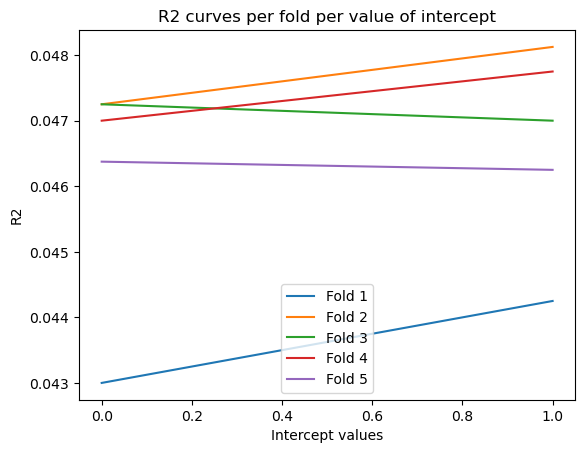

In [17]:
#Plor R2 per fold

results = r_results
param = 'param_model__fit_intercept'
xlabel = 'Intercept values'
ylabel = 'R2'
title = 'R2 curves per fold per value of intercept'

fold = 1
for r in results:

    plt.plot(r[param], r['mean_test_score'], label='Fold %s'%fold)
    plt.legend();
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);

    fold += 1

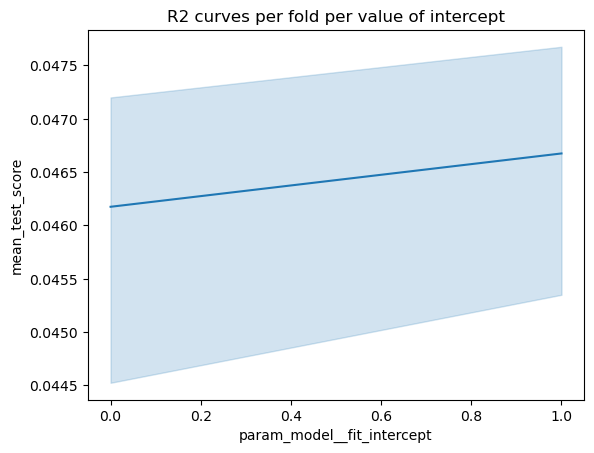

In [18]:
fold = 1
for r in results:
    r['fold'] = fold
    fold += 1
    
r = pd.concat(results)

param = ['param_model__fit_intercept']
title = 'R2 curves per fold per value of intercept'

#Plot R2 curves per parameters

s = sns.lineplot(x=r[param[0]], y=r['mean_test_score'], legend='full');
s.set(title=title);

In [19]:
#Best Parameters

r = pd.concat(r_results)
best = r[r['rank_test_score'] == 1]
p = best['params']
print(p)

0     {'model__fit_intercept': True}
0     {'model__fit_intercept': True}
1    {'model__fit_intercept': False}
0     {'model__fit_intercept': True}
1    {'model__fit_intercept': False}
Name: params, dtype: object


We can see how on average the model seems to perform better if the intercept is fitted, but the performance is quite poor at around 0.44-0.47 R2 score. We can see also that the fit_intercept parameter is not completely stable, as there are some folds where the best model would require us not to fit the intercept. Overall however, it seems that fitting the intercept delivers the best model in most of the cases.

We start saving our evaluation metrics in a dictionary to better compare them later:

In [20]:
metrics_dict = {}
metrics_dict['Logistic Regressor'] = {'R2': r_score, 'MSE': r_mse, 'RMSE': r_rmse, 'MAE': r_mae}

In [21]:
#Save the model with dill to avoid retraining

with open('log_model', 'wb') as file:
    dill.dump({'metrics': metrics_dict['Logistic Regressor'], 'results': r_results, 'model': r_model}, file)

### KNN Regressor

For the KNN regressor, one of the main steps is to choose the K parameter that defines the number of clusters in the model. Therefore:

In [22]:
#takes around 7 minutes

model = KNeighborsRegressor()
pipe_parameters = [{'model__n_neighbors': np.arange(1, 50, 1)}]

knn_model, knn_results, knn_score, knn_mse, knn_rmse, knn_mae = nested_cv(model, pipe_parameters, X_sample, y_sample, outer_splits=5, inner_splits=5)

5it [04:50, 58.03s/it]


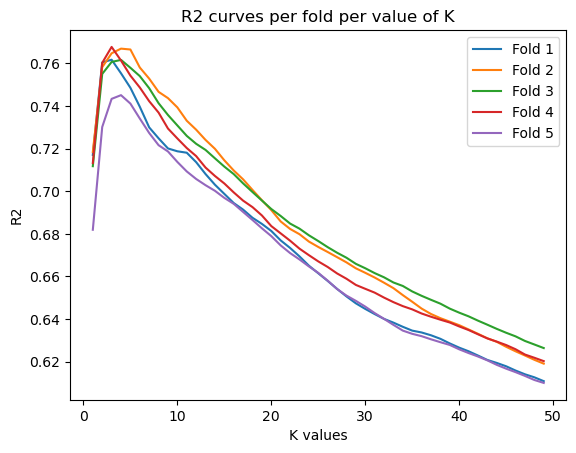

In [23]:
#Plor R2 per fold

results = knn_results
param = 'param_model__n_neighbors'
xlabel = 'K values'
ylabel = 'R2'
title = 'R2 curves per fold per value of K'

fold = 1
for r in results:

    plt.plot(r[param], r['mean_test_score'], label='Fold %s'%fold)
    plt.legend();
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);

    fold += 1

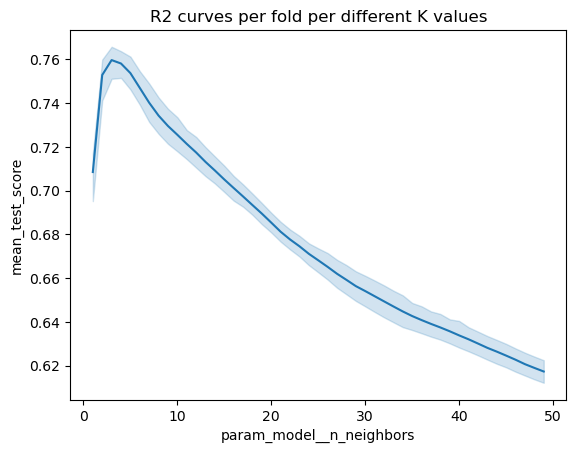

In [24]:
fold = 1
for r in results:
    r['fold'] = fold
    fold += 1
    
r = pd.concat(results)

param = ['param_model__n_neighbors']
title = 'R2 curves per fold per different K values'

#Plot R2 curves per parameters

s = sns.lineplot(x=r[param[0]], y=r['mean_test_score'], legend='full');
s.set(title=title);

In [25]:
#Best Parameters

r = pd.concat(knn_results)
best = r[r['rank_test_score'] == 1]
p = best['params']
print(p)

2    {'model__n_neighbors': 3}
3    {'model__n_neighbors': 4}
3    {'model__n_neighbors': 4}
2    {'model__n_neighbors': 3}
3    {'model__n_neighbors': 4}
Name: params, dtype: object


We can see how the best value for K is 3 or 4 clusters, as these are the values that maximize our model predictive power. Also here, values are not 100% stable, but overall it seems that a value of K equal to 4 achieves the best performance over our 5 folds.

In [26]:
metrics_dict['KNN Regressor'] = {'R2': knn_score, 'MSE': knn_mse, 'RMSE': knn_rmse, 'MAE': knn_mae}

In [27]:
#Save the model with dill to avoid retraining

with open('knn_model', 'wb') as file:
    dill.dump({'metrics': metrics_dict['KNN Regressor'], 'results': knn_results, 'model': knn_model}, file)

### SVR Model

For the SVR model, the main parameter to train is the kernel. Other hyperparameters like C and epsilon will be explored later, should the SVR model be the best performing one.

In [28]:
## SVR MODEL -- takes 10 minutes

model = SVR()
pipe_parameters = [{'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}]#, 'model__C': [0.1, 0.5, 1, 1.5], 'model__epsilon': [0.01, 0.05, 0.1, 0.15, 0.5]}]

svr_model, svr_results, svr_score, svr_mse, svr_rmse, svr_mae = nested_cv(model, pipe_parameters, X_sample, y_sample, outer_splits=5, inner_splits=5)

5it [09:53, 118.72s/it]


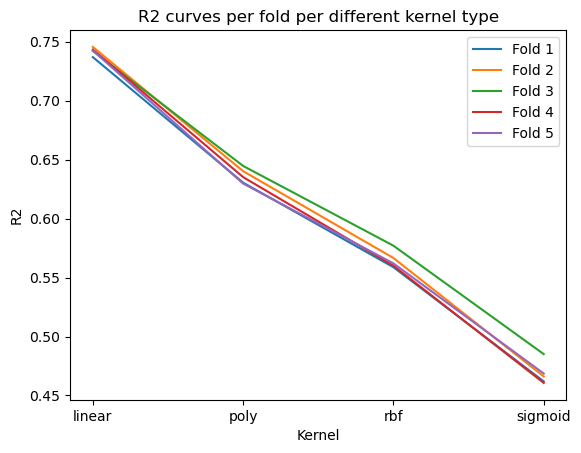

In [29]:
#Plor R2 per fold
results = svr_results
param = 'param_model__kernel'
xlabel = 'Kernel'
ylabel = 'R2'
title = 'R2 curves per fold per different kernel type'

fold = 1
for r in results:

    plt.plot(r[param], r['mean_test_score'], label='Fold %s'%fold)
    plt.legend();
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);

    fold += 1

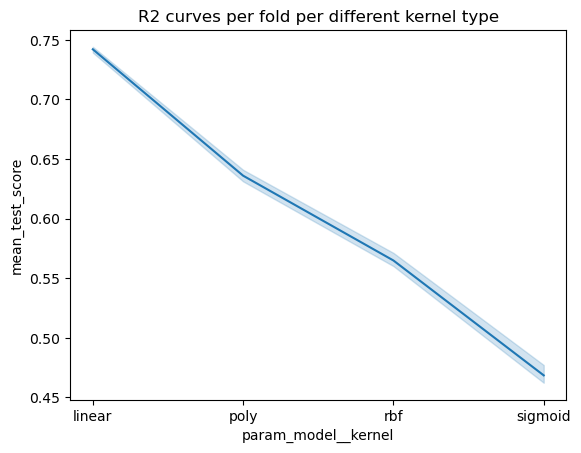

In [30]:
fold = 1
for r in results:
    r['fold'] = fold
    fold += 1
    
r = pd.concat(results)

param = ['param_model__kernel']
title = 'R2 curves per fold per different kernel type'

#Plot R2 curves per parameters

s = sns.lineplot(x=r[param[0]], y=r['mean_test_score'], legend='full');
s.set(title=title);

In [31]:
#Best Parameters

r = pd.concat(svr_results)
best = r[r['rank_test_score'] == 1]
p = best['params']
print(p)

0    {'model__kernel': 'linear'}
0    {'model__kernel': 'linear'}
0    {'model__kernel': 'linear'}
0    {'model__kernel': 'linear'}
0    {'model__kernel': 'linear'}
Name: params, dtype: object


We can clearly see this time that the best kernel for our data is clearly the linear one. It is the best performer in every fold analyzed.

In [32]:
metrics_dict['SVR Regressor'] = {'R2': svr_score, 'MSE': svr_mse, 'RMSE': svr_rmse, 'MAE': svr_mae}

In [33]:
#Save the model with dill to avoid retraining

with open('svr_model', 'wb') as file:
    dill.dump({'metrics': metrics_dict['SVR Regressor'], 'results': svr_results, 'model': svr_model}, file)

### Passive-Aggresive Regressor

In [34]:
##PA REGRESSION -- takes 1 minute

model = PassiveAggressiveRegressor(random_state=random_state)
pipe_parameters = [{'model__fit_intercept': [True, False]}]

pa_model, pa_results, pa_score, pa_mse, pa_rmse, pa_mae = nested_cv(model, pipe_parameters, X_sample, y_sample, outer_splits=5, inner_splits=5)

5it [00:09,  1.93s/it]


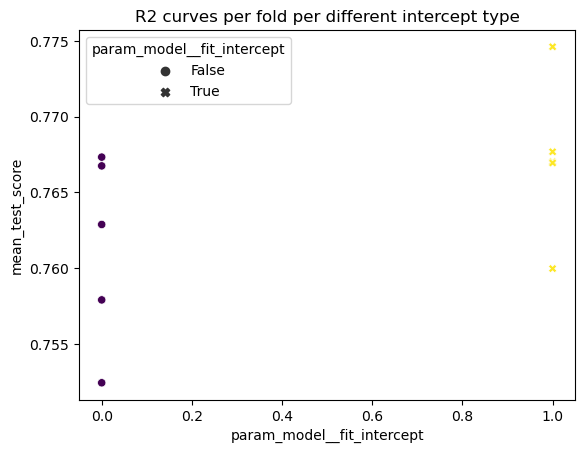

In [35]:
#Plot R2 curves per fold

results = pa_results
r = pd.concat(results)
param = ['param_model__fit_intercept']
title = 'R2 curves per fold per different intercept type'

#Plot R2 curves per parameters

s = sns.scatterplot(x=r[param[0]], y=r['mean_test_score'], c=r[param[0]], style=r[param[0]]);
s.set(title=title);


In [36]:
#Best Parameters

best = r[r['rank_test_score'] == 1]
p = best['params']
print(p)

0    {'model__fit_intercept': True}
0    {'model__fit_intercept': True}
0    {'model__fit_intercept': True}
0    {'model__fit_intercept': True}
0    {'model__fit_intercept': True}
Name: params, dtype: object


Also in this case, all the folds seem to agree that the best model has the intercept fitted. 

In [37]:
metrics_dict['PA Regressor'] = {'R2': pa_score, 'MSE': pa_mse, 'RMSE': pa_rmse, 'MAE': pa_mae}

In [38]:
#Save the model with dill to avoid retraining

with open('pa_model', 'wb') as file:
    dill.dump({'metrics': metrics_dict['PA Regressor'], 'results': pa_results, 'model': pa_model}, file)

### SGD Regressor

For the SGD regressor, we fit the model on different values of penalty, intercept fitting, and alpha.

In [39]:
##SGD REGRESSOR - it takes around 10minutes

model = SGDRegressor(random_state=random_state)
pipe_parameters = [{'model__penalty': ['l2', 'l1', 'elasticnet'], 'model__fit_intercept': [True, False]}]

sgd_model, sgd_results, sgd_score, sgd_mse, sgd_rmse, sgd_mae = nested_cv(model, pipe_parameters, X_sample, y_sample, outer_splits=5, inner_splits=5)

5it [03:38, 43.64s/it]


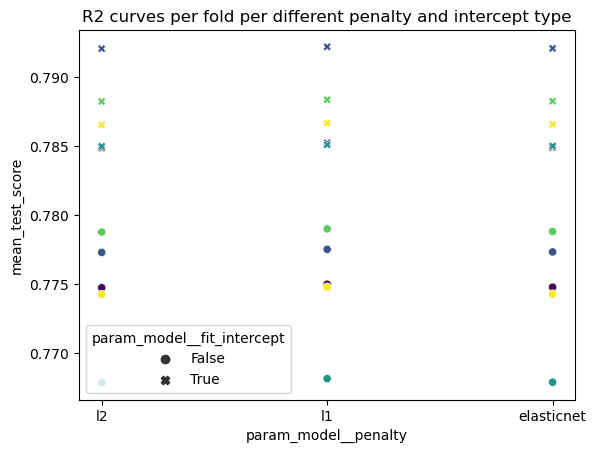

In [40]:
results = sgd_results

fold = 1
for r in results:
    r['fold'] = fold
    fold += 1
    
r = pd.concat(results)
param = ['param_model__penalty', 'param_model__fit_intercept']
title = 'R2 curves per fold per different penalty and intercept type'

#Plot R2 curves per parameters

s = sns.scatterplot(x=r[param[0]], y=r['mean_test_score'], c=r['fold'], style=r[param[1]], legend='full');
s.set(title=title);

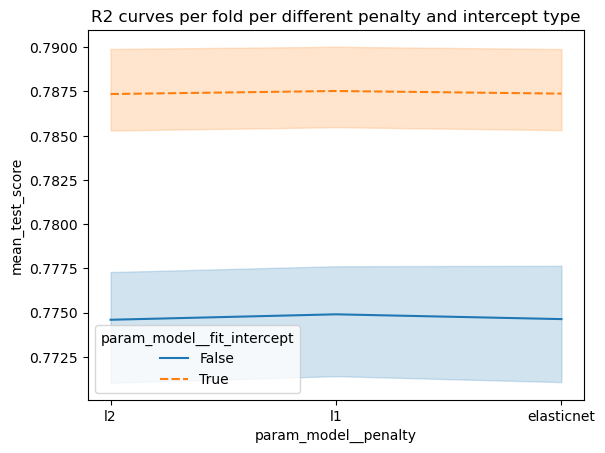

In [41]:
param = ['param_model__penalty', 'param_model__fit_intercept']
title = 'R2 curves per fold per different penalty and intercept type'

#Plot R2 curves per parameters

s = sns.lineplot(x=r[param[0]], y=r['mean_test_score'], style=r[param[1]], hue=r[param[1]], legend='full');
s.set(title=title);

In [42]:
#Best Parameters

best = r[r['rank_test_score'] == 1]
p = best['params']
print(p)

1    {'model__fit_intercept': True, 'model__penalty...
1    {'model__fit_intercept': True, 'model__penalty...
1    {'model__fit_intercept': True, 'model__penalty...
1    {'model__fit_intercept': True, 'model__penalty...
1    {'model__fit_intercept': True, 'model__penalty...
Name: params, dtype: object


All the folds agree here, that the intercept should be fitted. The best penalty type to apply to our model is the L1 regularization.

In [43]:
metrics_dict['SGD Regressor'] = {'R2': sgd_score, 'MSE': sgd_mse, 'RMSE': sgd_rmse, 'MAE': sgd_mae}

In [44]:
#Save the model with dill to avoid retraining

with open('sgd_model', 'wb') as file:
    dill.dump({'metrics': metrics_dict['SGD Regressor'], 'results': sgd_results, 'model': sgd_model}, file)

### MLP Regressor

For the MLP regressor, we will train it on multiple values for the hidden layer, and also on different types of activation functions. A full parameter sweep for MLP is extremely costly to compute, so at the moment we limit ourselves to these two parameters. Other hyperparameters can be explored subsequently if the model is judged to be the best performing one.

In [45]:
##MLP REGRESSOR - it takes 2h!

model = MLPRegressor(max_iter=10000, random_state=random_state, early_stopping=True)
pipe_parameters = [{'model__hidden_layer_sizes': [(100, ), (250, ), (100, 10)], 
                    'model__activation': ['identity', 'logistic', 'tanh', 'relu']}]

mlp_model, mlp_results, mlp_score, mlp_mse, mlp_rmse, mlp_mae = nested_cv(model, pipe_parameters, X_sample, y_sample, outer_splits=5, inner_splits=5)

5it [1:45:46, 1269.30s/it]


In [46]:
saaaave = clone(mlp_model)

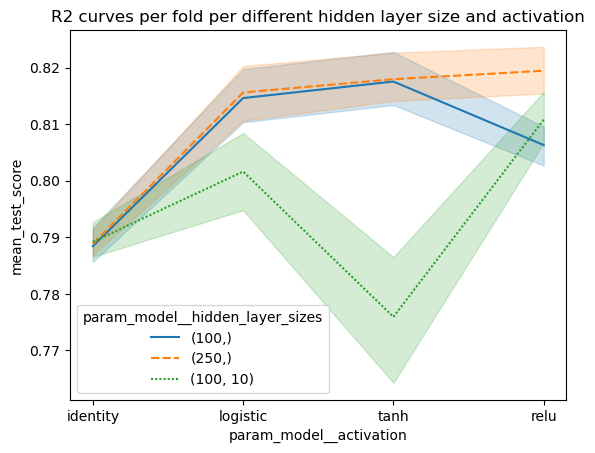

In [47]:
results = mlp_results

fold = 1
for r in results:
    r['fold'] = fold
    fold += 1

r = pd.concat(results)
param = ['param_model__activation', 'param_model__hidden_layer_sizes']
title = 'R2 curves per fold per different hidden layer size and activation'

#Plot R2 curves per parameters

s = sns.lineplot(x=r[param[0]], y=r['mean_test_score'], style=r[param[1]], hue=r[param[1]], legend='full');
s.set(title=title);

In [48]:
#Best Parameters

best = r[r['rank_test_score'] == 1]
p = best['params']
pd.DataFrame([x for x in p.values])

,model__activation,model__hidden_layer_sizes
0,relu,"(250,)"
1,tanh,"(100,)"
2,relu,"(250,)"
3,logistic,"(250,)"
4,logistic,"(100,)"


We can see from the table how the results are a bit different for every fold, with the logistic activation function which seems to be the best for simple models, while the ReLu is performing very well on more complex ones. Overall, our estimator, as evidenced by the best_estimator_ method of GridSearch, chooses a model with a Logistic activation function and 100 hidden layers.

In [49]:
metrics_dict['MLP Regressor'] = {'R2': mlp_score, 'MSE': mlp_mse, 'RMSE': mlp_rmse, 'MAE': mlp_mae}

In [50]:
#Save the model with dill to avoid retraining

with open('mlp_model', 'wb') as file:
    dill.dump({'metrics': metrics_dict['MLP Regressor'], 'results': mlp_results, 'model': mlp_model}, file)

### Models Summary and Prediction

We can now look at the results for the different metrics of our regressors, by looking at their mean and standard deviation across the different folds:

In [51]:
#Summary table of metrics for mean

metrics = {}
for model in metrics_dict:
    averages = []
    for metric in metrics_dict[model]:
        averages.append(np.mean(metrics_dict[model][metric]))
    
    metrics[model] = averages
 

metrics_df = pd.DataFrame(metrics, index=['R2', 'MSE', 'RMSE', 'MAE'])

metrics_df.apply(lambda x: x.apply('{0:.5f}'.format))

,Logistic Regressor,KNN Regressor,SVR Regressor,PA Regressor,SGD Regressor,MLP Regressor
R2,0.38070,0.77241,0.75215,0.76732,0.79116,0.81913
MSE,1022.04080,375.12619,409.15374,383.18540,344.32265,298.67123
RMSE,31.92821,19.33655,20.19958,19.55839,18.53522,17.25006
MAE,21.20880,12.82763,13.56340,13.88914,13.17711,11.86880


In [52]:
#Summary table of metrics for std

metrics_std = {}
for model in metrics_dict:
    stds = []
    for metric in metrics_dict[model]:
        stds.append(np.std(metrics_dict[model][metric]))
    
    metrics_std[model] = stds
 

metrics_std_df = pd.DataFrame(metrics_std, index=['R2', 'MSE', 'RMSE', 'MAE'])

metrics_std_df.apply(lambda x: x.apply('{0:.5f}'.format))

,Logistic Regressor,KNN Regressor,SVR Regressor,PA Regressor,SGD Regressor,MLP Regressor
R2,0.02360,0.01867,0.01034,0.01112,0.00950,0.01253
MSE,103.90162,44.00590,42.44753,31.47378,32.53896,36.44633
RMSE,1.62170,1.10641,1.06340,0.80929,0.87647,1.05202
MAE,0.92818,0.45183,0.54078,0.65735,0.47233,0.54210


We can see how most of the models perform similarly, except for the Logistic regressor, however the MLP Regressor seem to be the best performer according to all the metrics.

In [57]:
#Save the best MLP model for our analysis
best_mlp = mlp_model.best_estimator_

We can use it to predict the missing values for CO2 emissions in 2021 as follows.

First, we get the rows for 2021 that have missing CO2 emissions:

In [58]:
#Copy the original data
dataframe = df1

#Get the dummy variables
ohe_data = pd.get_dummies(dataframe, columns=ohe_columns)

#get names of the one hot encoded cols 
ohe_cols = [col for col in ohe_data if col.startswith(('Ft', 'Fm', 'Mh'))]

#Features are all the numerical data + the one hot encoded (ohe) ones
features =  num_features + ohe_cols

#Include only 2021
excluded_col_val = ('year', 2021, 'include')
df_21 = ohe_data[ohe_data[excluded_col_val[0]] == excluded_col_val[1]][features]

#Drop columns which don't have all the features used by our prediction model
df_21.dropna(subset=[col for col in df_21.columns if 'Enedc' not in col], how='any', inplace=True)

df_21.reset_index(drop=True, inplace=True)
  


In [59]:
#Get all the rows with missing CO2 emissions
missing_data_2021 = df_21[df_21['Enedc (g/km)'].isna()]


In [60]:
#Our X to predict 2021 missing values is the dataframe as obtained from the previous cells, minus the target 
X_21 = missing_data_2021.drop('Enedc (g/km)', axis=1)

#Make the predictions with our best model (MLP)
predictions = best_mlp.predict(X_21)

#Inpute the predictions in our missing data df
missing_data_2021['Enedc (g/km)'] = predictions


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


We can visualize our predictions versus the original data to see if the predicted data matches the original distribution:

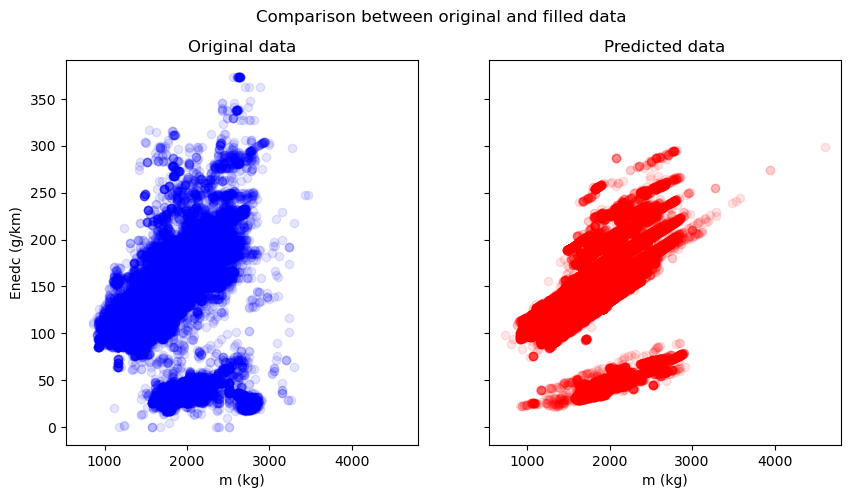

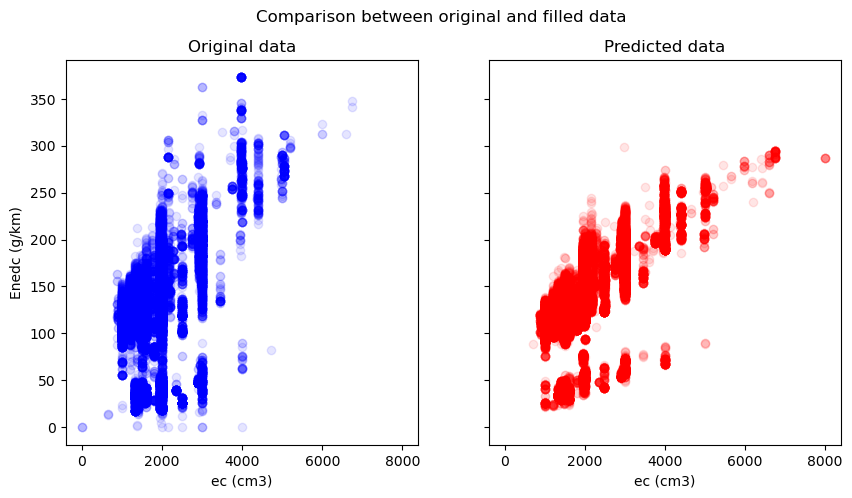

In [61]:
predicted_data = missing_data_2021

original = df_21.dropna(subset=['Enedc (g/km)'])
original = original.dropna(how='any')

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Comparison between original and filled data');
fig.set_size_inches(10, 5);
ax[0].scatter(original['m (kg)'], original['Enedc (g/km)'], color='blue', alpha=0.1);
ax[0].set_title('Original data');
ax[0].set_xlabel('m (kg)');
ax[0].set_ylabel('Enedc (g/km)');
ax[1].scatter(predicted_data['m (kg)'], predicted_data['Enedc (g/km)'], color='red', alpha=0.1);
ax[1].set_title('Predicted data');
ax[1].set_xlabel('m (kg)');

plt.show();

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Comparison between original and filled data');
fig.set_size_inches(10, 5);
ax[0].scatter(original['ec (cm3)'], original['Enedc (g/km)'], color='blue', alpha=0.1);
ax[0].set_title('Original data');
ax[0].set_xlabel('ec (cm3)');
ax[0].set_ylabel('Enedc (g/km)');
ax[1].scatter(predicted_data['ec (cm3)'], predicted_data['Enedc (g/km)'], color='red', alpha=0.1);
ax[1].set_title('Predicted data');
ax[1].set_xlabel('ec (cm3)');

plt.show();

As we can see, the prediction seem to match the original data, so we can assume that the filled values are representative and consistent with the features of each car in our dataset. 

We can now fill the original dataset to have a clean, filled version of it (basically, we need to go back from one-hot encoded values to the original labels). So:

In [62]:
#CREATE A FULL DATAFRAME FOR 2021 DATA WITH PREDICTED VALUES

#Get original 2021 data with missing enedc and full features
df2 = df1.reset_index(drop=True)
final_df = df2[df2['year'] == 2021] 
final_df = final_df[final_df['Enedc (g/km)'].isna()]
cols = [col for col in final_df.columns if not(col.startswith('Enedc'))]
final_df.dropna(subset=cols, how='any', inplace=True)

In [63]:
#Create a dataframe which will contain our predictions
predict_df = df2

predict_df = pd.get_dummies(predict_df, columns=ohe_columns)

predict_df = predict_df[predict_df['year'] == 2021] 
predict_df = predict_df[predict_df['Enedc (g/km)'].isna()]
predict_df.dropna(subset=[col for col in predict_df.columns if not(col.startswith('Enedc'))], how='any', inplace=True)

#get names of the one hot encoded cols 
ohe_cols_final = [col for col in predict_df if col.startswith(('Ft', 'Fm', 'Mh'))]

#Features are all the numerical data + the one hot encoded (ohe) ones
features = ['m (kg)', 'Enedc (g/km)', 'ec (cm3)', 'year'] + ohe_cols_final

predict_df = predict_df[features]

X_final = predict_df.drop('Enedc (g/km)', axis=1)

#Do the predictions
enedc_pred = mlp_model.predict(X_final)

#Add the predicted values to the df
predict_df['Enedc (g/km)'] = enedc_pred

In [64]:
#Add the predicted values to the initial df (without scaling or one hot encoding)
final_df['Enedc (g/km)'] = final_df.index.to_series().map(predict_df['Enedc (g/km)'])

#Alternative way but less elegant
#pd.merge(left=final_df, right=predict_df['Enedc (g/km)'], how='left', left_index=True, right_index=True)

#Save our dataframe of predicted values for 2021 for future use:
final_df.to_pickle('predicted_2021')

In [65]:
#We merge our previous 2021 dataset to the original one 
#FULL DATASET ALL YEARS + PREDICTED VALS

filled_df = pd.merge(left=df1, right=final_df, how='left', left_on=['Country', 'Mh', 'Man', 'Mk', 'Cn', 'm (kg)', 'Ft', 'Fm', 'ec (cm3)', 'year'],
right_on=['Country', 'Mh', 'Man', 'Mk', 'Cn', 'm (kg)', 'Ft', 'Fm', 'ec (cm3)', 'year'])

filled_df['Enedc (g/km)'] = filled_df['Enedc (g/km)_x'].fillna(0) + filled_df['Enedc (g/km)_y'].fillna(0)

filled_df.drop(['Enedc (g/km)_x', 'Enedc (g/km)_y'], axis=1, inplace=True)

## Feature importance/ablation

To check feature importance, unfortunately our MLP estimator does not have any integrated method in Scikit to calculate them. So, we choose different approaches and compare the differences. First, we try to create our own approach based on feature ablation. We train different models by including more and more features in it, and calculate the difference in evaluation metrics between models that include the feature and models that don't. As we have one-hot encoded features, we will group them and consider all the columns related to the original categorical feature to be a single column.

In [66]:
#Create the groups of columns related to one-hot encoded categorical variables
ft_col = [col for col in X_sample.columns if col.startswith('Ft')]
fm_col = [col for col in X_sample if col.startswith('Fm')]
mh_col = [col for col in X_sample if col.startswith('Mh')]

features = ['m (kg)', 'ec (cm3)', 'year', ft_col, fm_col, mh_col]
#features = ['m (kg)', 'Enedc (g/km)', 'ec (cm3)', 'year', 'Ft', 'Fm', 'Mh']

#Compute all the possible combinations of our features
features_space = []
#We start by considering different lengths of feature, from a single one to the complete model
for L in range(len(features) + 1):
    #Calculate the combinations of length L for each feature
    for subset in itertools.combinations(features, L):
        features_space.append(subset)


features_space = [list(x) for x in features_space]

#We flatten the different lists in order to have a single list of feature that we can pass to pandas when doing the ablation
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, str):
            yield from flatten(x)
        else:
            yield x

for i, feature in enumerate(features_space):
    features_space[i] = list(flatten(feature))

#We exclude the initial feature in our features space which is simply an empty list
features_space = features_space[1:]

We can now do the actual feature ablation, which is just our pipeline trained over 5 folds for different values of sample size:

In [67]:
#It takes 100 minutes 

models_ablation = {}

ablation_mlp = clone(best_mlp)

#Create the scaler and pipeline
scaler_ablation = MinMaxScaler(feature_range=(0, 1))

pipeline_ablation = Pipeline([('scaler', scaler_ablation), ('model', ablation_mlp)])

#Iterate over the feature space and compute one model per each, over 5 folds, and save the relevant evaluation metrics for each
for feature in tqdm(features_space):
    #Build folds
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    mae_abl = []
    rmse_abl = []
    mse_abl = []
    r2_abl = []

    #Iterate over the folds
    for train_index , test_index in tqdm(cv.split(X_sample)):
        X_ = X_sample[feature]
        y_ = y_sample
        X_train , X_test = X_.iloc[train_index,:], X_.iloc[test_index,:]
        y_train , y_test = y_[train_index] , y_[test_index]
        
        pipeline_ablation.fit(X_train,y_train)

        pred = pipeline_ablation.predict(X_test)

        mse_ = mean_squared_error(pred, y_test)
        rmse_ = sqrt(mse_)
        mae_ = mean_absolute_error(pred, y_test)
        r2_ = r2_score(pred, y_test)

        mae_abl.append(mae_)
        rmse_abl.append(rmse_)
        mse_abl.append(mse_)
        r2_abl.append(r2_)

    models_ablation[tuple(feature)] = {'MSE': mse_abl, 'RMSE': rmse_abl, 'MAE': mae_abl, 'R2': r2_abl}
    


5it [00:37,  7.42s/it][00:00<?, ?it/s]
5it [00:44,  8.98s/it][00:37<38:21, 37.12s/it]
5it [00:28,  5.77s/it][01:22<42:24, 41.71s/it]
5it [00:24,  4.84s/it][01:50<35:50, 35.85s/it]
5it [00:13,  2.74s/it][02:15<30:43, 31.25s/it]
5it [02:00, 24.10s/it][02:28<24:05, 24.93s/it]
5it [00:44,  8.96s/it][04:29<54:33, 57.43s/it]
5it [00:56, 11.26s/it][05:14<49:44, 53.30s/it]
5it [00:51, 10.34s/it][06:10<49:43, 54.25s/it]
5it [01:01, 12.30s/it][07:02<48:06, 53.46s/it]
5it [02:44, 32.96s/it] [08:03<49:24, 55.94s/it]
5it [00:52, 10.58s/it] [10:48<1:17:21, 89.26s/it]
5it [00:54, 10.91s/it] [11:41<1:06:28, 78.21s/it]
5it [01:05, 13.16s/it] [12:35<59:11, 71.04s/it]  
5it [01:51, 22.24s/it] [13:41<56:43, 69.46s/it]
5it [00:39,  7.84s/it] [15:32<1:05:38, 82.05s/it]
5it [00:46,  9.37s/it] [16:12<54:10, 69.16s/it]  
5it [02:31, 30.22s/it] [16:59<47:52, 62.45s/it]
5it [00:32,  6.49s/it] [19:30<1:06:48, 89.08s/it]
5it [02:11, 26.24s/it] [20:02<52:51, 72.08s/it]  
5it [02:51, 34.30s/it] [22:13<1:04:22, 89.83

In [68]:
#Save the ablation with dill to avoid retraining

with open('ablation', 'wb') as file:
    dill.dump({'model': pipeline_ablation, 'results': models_ablation}, file)

We can now plot the importance of our different features. First of all, we accumulate the different metrics for every time a feature is in the trained model. So for example, our dictionary will contain the R2 for the engine capacity feature every time that feature appears in the model. Basically, we get the distribution of the evaluation metrics for every time that a feature is inserted in the model. 

Text(0.5, 1.0, 'R2 scores ablation for feature')

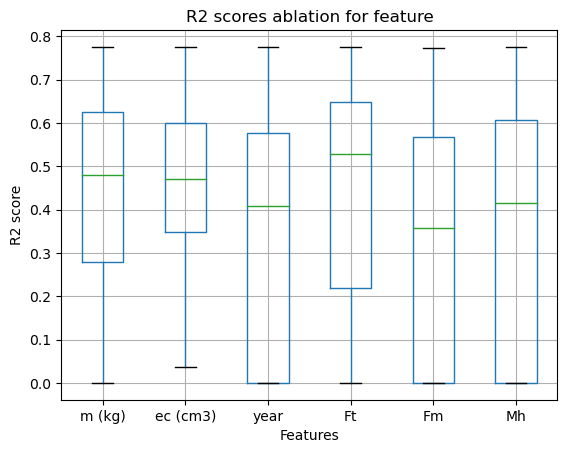

In [69]:
R2_scores = {}

#Iterate over our features
for feature in features:
    r2s = []
    #Save the r2 if the model contains the current feature
    for r2 in models_ablation:
        if ''.join(feature) in ''.join(r2):
            r2s.append(models_ablation[(r2)]['R2'])

    #Create a dictionary to contain all the R2 for our feature
    R2_scores[','.join(feature)] = np.mean(r2s, axis=1)

r2_df = pd.DataFrame(R2_scores)
r2_df.columns = ['m (kg)', 'ec (cm3)', 'year', 'Ft', 'Fm', 'Mh']
#Exclude negative R2 values (sklearn computes the adjusted R2 which can be negative). This is to avoid getting non significant plots.
r2_df[r2_df < 0] = 0

#Create a boxplot showing the distribution of R2 for different features
g = r2_df.boxplot()
g.set_xlabel('Features')
g.set_ylabel('R2 score')
g.set_title('R2 scores ablation for feature')

Text(0.5, 1.0, 'MAE distribution for different models containing the feature')

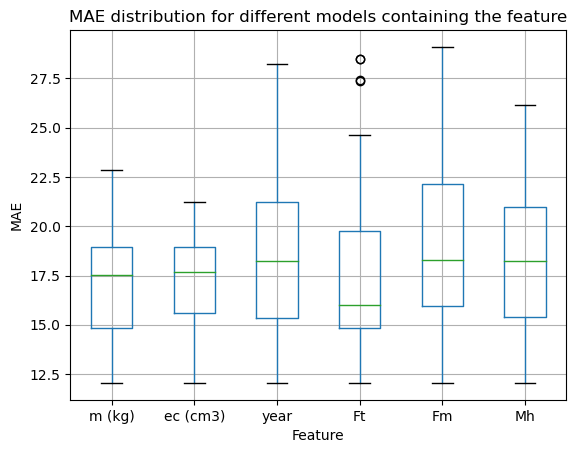

In [70]:
MAE_scores = {}

for feature in features:
    maes = []
    for mae in models_ablation:
        if ''.join(feature) in ''.join(mae):
            maes.append(models_ablation[(mae)]['MAE'])
    MAE_scores[','.join(feature)] = np.mean(maes, axis=1)

mae_df = pd.DataFrame(MAE_scores)
mae_df.columns = ['m (kg)', 'ec (cm3)', 'year', 'Ft', 'Fm', 'Mh']

f = mae_df.boxplot()
f.set_xlabel('Feature')
f.set_ylabel('MAE')
f.set_title('MAE distribution for different models containing the feature')




Text(0.5, 1.0, 'RMSE ablation for feature')

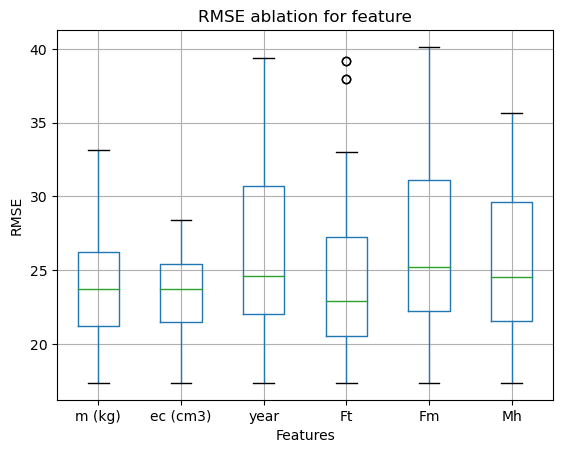

In [71]:
RMSE_scores = {}

for feature in features:
    rmses = []
    for rmse in models_ablation:
        if ''.join(feature) in ''.join(rmse):
            rmses.append(models_ablation[(rmse)]['RMSE'])
    RMSE_scores[','.join(feature)] = np.mean(rmses, axis=1)

rmse_df = pd.DataFrame(RMSE_scores)
rmse_df.columns = ['m (kg)', 'ec (cm3)', 'year', 'Ft', 'Fm', 'Mh']\

g = rmse_df.boxplot()
g.set_xlabel('Features')
g.set_ylabel('RMSE')
g.set_title('RMSE ablation for feature')

We can see from our plot that with model ablation, most of our features seem to be significant. The most important one seems to be the Fuel Type, which maximizes the R2 and minimizes the errors. It has however a wide range of values, which could mean that it performs poorly if used by itself or in combination with other features. 

To try another approach, we use SHAP, which allows to build a model explainer based on MLP. We proceed as follows:

In [72]:
#Create the sample again as we played with it a bit in the previous cells
dataframe = df1
y = 'Enedc (g/km)'
ohe_columns = ['Ft', 'Fm', 'Mh']
num_features = ['m (kg)', 'Enedc (g/km)', 'ec (cm3)', 'year']
excluded_col_val = ('year', 2021, 'exclude')
sample_size = 10000
random_state = 42

X_sample, y_sample = preprocess_data(dataframe, y, ohe_columns, num_features, excluded_col_val, sample_size, random_state)

In [74]:
#Create a smaller sample of train and tests set to perform the features importance analysis with SHAP
X_train, X_test, y_train, y_test = train_test_split(X_sample[:1000], y_sample[:1000], random_state=random_state, test_size=0.3)

#Create a copy of our model
shap_mlp = best_mlp
# Explain model predictions using shap library:
explainer = shap.KernelExplainer(shap_mlp.predict, X_train)
shap_values = explainer.shap_values(X_test, nsamples=100)

X does not have valid feature names, but MinMaxScaler was fitted with feature names
Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but MinMaxScaler was fitted with feature names
X does not have valid feature names, but MinMaxScaler was fitted with feature names
The default of 'normalize' will be se

After training the explainer, we can visualize the features importance though a SHAP Summary Plot. Before proceeding, we group our dummies for categorical features to improve visualization:

In [75]:
shap.initjs()
#i_ft = []
#i_fm = []
#i_mh = []

#[i_ft.append(X_train.columns.tolist().index(x)) for x in X_train.columns if x.startswith('Ft')];
#[i_fm.append(X_train.columns.tolist().index(x)) for x in X_train.columns if x.startswith('Fm')];
#[i_mh.append(X_train.columns.tolist().index(x)) for x in X_train.columns if x.startswith('Mh')];

#groups = [[0], [1], [2], i_ft, i_fm, i_mh]

#Names of the grouped variables
groups_names = ['m (kg)', 'ec (cm3)', 'year', 'Ft', 'Fm', 'Mh']

#Create a modified shap values dataframe with the groupings
mod_shap = pd.DataFrame(shap_values)
mod_shap.columns = X_train.columns

X_test_mod = X_test


#For each categorical features, sum the shap values 
ft_col = [x for x in mod_shap.columns if x.startswith('Ft')]
mod_shap['Ft'] = mod_shap[ft_col].sum(axis=1)
X_test_mod['Ft'] = X_test_mod[ft_col].sum(axis=1)
mod_shap.drop(ft_col, axis=1, inplace=True)
X_test_mod.drop(ft_col, axis=1, inplace=True)

fm_col = [x for x in mod_shap.columns if x.startswith('Fm')]
mod_shap['Fm'] = mod_shap[fm_col].sum(axis=1)
X_test_mod['Fm'] = X_test_mod[fm_col].sum(axis=1)
mod_shap.drop(fm_col, axis=1, inplace=True)
X_test_mod.drop(fm_col, axis=1, inplace=True)

mh_col = [x for x in mod_shap.columns if x.startswith('Mh')]
mod_shap['Mh'] = mod_shap[mh_col].sum(axis=1)
X_test_mod['Mh'] = X_test_mod[mh_col].sum(axis=1)
mod_shap.drop(mh_col, axis=1, inplace=True)
X_test_mod.drop(mh_col, axis=1, inplace=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


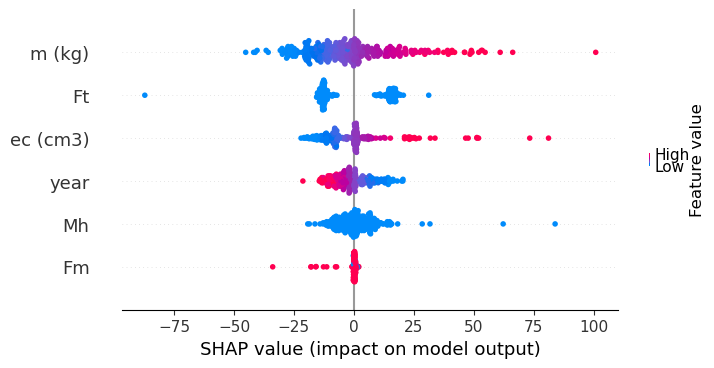

In [76]:
shap.summary_plot(mod_shap.to_numpy(), X_test_mod, feature_names=groups_names)

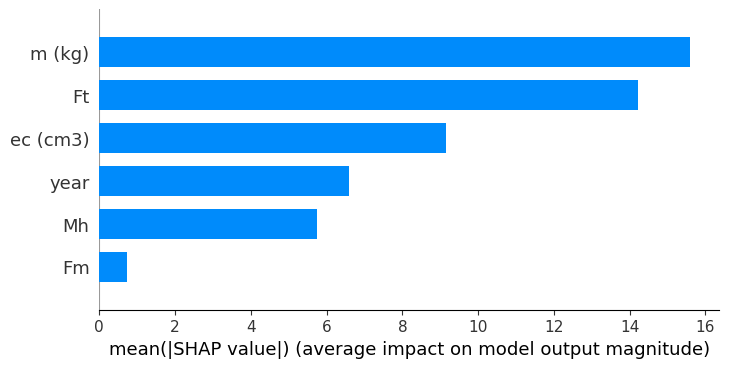

In [77]:
shap.summary_plot(mod_shap.to_numpy(),X_test_mod,feature_names=groups_names, plot_type='bar')

We can see how, according to SHAP, the most important feature is the mass, followed by the fuel type and engine capacity. The other features have lower importance, but still significant. This is in agreement with our features ablation. We can also try to visualize one single point to check which variables influence the prediction:

In [78]:
shap.force_plot(explainer.expected_value, mod_shap.to_numpy()[5,:], X_test_mod.iloc[5],feature_names=groups_names)

This tells us that engine capacity and mass can greatly influence the predicted value, together with the fuel type. In this case, both mass and engine capacity push the prediction higher, while the fuel type pushes the prediction lower.

#### Learning curve analysis

We can also analyze our model to check how many observations are needed for it to converge to a good performance according to our metrics. To do so, we train it on different sample sizes, and check the performance metrics. So:

In [79]:
#Get the full dataset and prepare it for training

dataframe = df1
y = 'Enedc (g/km)'
ohe_columns = ['Ft', 'Fm', 'Mh']
num_features = ['m (kg)', 'Enedc (g/km)', 'ec (cm3)', 'year']
excluded_col_val = ('year', 2021, 'exclude')

random_state = 42

X, y = preprocess_data(dataframe, y, ohe_columns, num_features, excluded_col_val)

In [80]:
#Run the training on every dataset sample size and save the performance metrics
#It takes 35 min

models_learning = {}

sample_mlp = clone(best_mlp)

scaler_sample = MinMaxScaler(feature_range=(0, 1))

pipeline_sample = Pipeline([('scaler', scaler_sample), ('model', sample_mlp)])

learning_samples = [100, 1000, 10000, 20000, 50000, 100000, 250000]
for learning in tqdm(learning_samples):
    #Build folds
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    mse = []
    rmse = []
    mae = []
    r2 = []
    model_ = []

    #Iterate the training over different sample sizes 
    for train_index , test_index in tqdm(cv.split(X[:learning])):
        X_ = X[:learning]
        y_ = y[:learning]
        X_train , X_test = X_.iloc[train_index,:], X_.iloc[test_index,:]
        y_train , y_test = y_[train_index] , y_[test_index]
        
        pipeline_sample.fit(X_train,y_train)

        pred = pipeline_sample.predict(X_test)

        mse_ = mean_squared_error(pred, y_test)
        rmse_ = sqrt(mse_)
        mae_ = mean_absolute_error(pred, y_test)
        r2_ = r2_score(pred, y_test)

        mse.append(mse_)
        rmse.append(rmse_)
        mae.append(mae_)
        r2.append(r2_)
        model_.append(pipeline_sample)

    models_learning[learning] = {'RES': model_, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

5it [00:21,  4.33s/it]00:00<?, ?it/s]
5it [00:38,  7.77s/it]00:21<02:09, 21.63s/it]
5it [02:05, 25.18s/it]01:00<02:38, 31.77s/it]
5it [03:10, 38.02s/it]03:06<04:59, 74.76s/it]
5it [10:01, 120.27s/it]6:16<06:00, 120.29s/it]
5it [18:17, 219.55s/it]6:17<09:47, 293.77s/it]
5it [34:54, 418.98s/it]4:35<09:27, 567.12s/it]
100%|██████████| 7/7 [1:09:30<00:00, 595.78s/it] 


In [81]:
#Create a dataframe from our metrics and calculate the mean and std of the main ones
sample_df = pd.DataFrame(models_learning)

learning_mean_rmse = sample_df.iloc[2].apply(lambda x: np.mean(x))
learning_std_rmse = sample_df.iloc[2].apply(lambda x: np.std(x))

learning_mean_mae = sample_df.iloc[3].apply(lambda x: np.mean(x))
learning_std_mae = sample_df.iloc[3].apply(lambda x: np.std(x))

learning_mean_r2 = sample_df.iloc[4].apply(lambda x: np.mean(x))
learning_std_r2 = sample_df.iloc[4].apply(lambda x: np.std(x))

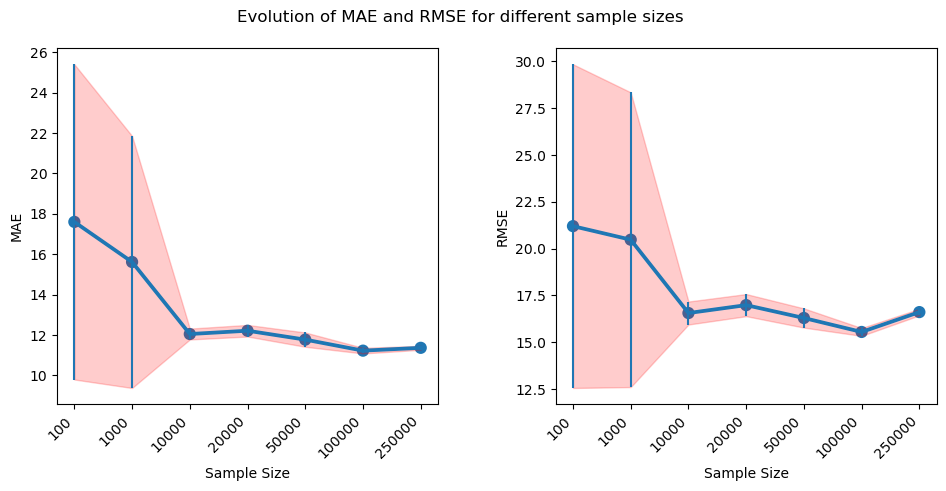

In [82]:
#Plot them on an error bar plot with confidence intervals:

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
 
s_mae = sns.pointplot(x=learning_mean_mae.index, y=learning_mean_mae, ax=ax1);
# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in s_mae.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
s_mae.errorbar(x=x_coords, y=y_coords, yerr=learning_std_mae)
lower = learning_mean_mae - learning_std_mae
upper = learning_mean_mae + learning_std_mae
s_mae.fill_between(x_coords, lower, upper, alpha=0.2, color='red')


s_rmse = sns.pointplot(x=learning_mean_rmse.index, y=learning_mean_rmse, ax=ax2);
# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in s_rmse.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
s_rmse.errorbar(x=x_coords, y=y_coords, yerr=learning_std_rmse)
lower = learning_mean_rmse - learning_std_rmse
upper = learning_mean_rmse + learning_std_rmse
s_rmse.fill_between(x_coords, lower, upper, alpha=0.2, color='red')

ax1.set_xlabel('Sample Size')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2.set_xlabel('Sample Size')
fig.suptitle('Evolution of MAE and RMSE for different sample sizes')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.tight_layout()
fig.set_size_inches(10, 5)


We can see how the sample size is very important for the performance of our model. Error metrics decrease as the training sample size increases, and the confidence intervals get much smaller as we pass from 1,000 to 10,000 training samples. We can say then that 10,000 training sample is the best trade-off between model performance and training time.

## Error Analysis

We can now perform error analysis for our model. First of all, we calculate the predictions of our best model and calculate the error versus the true value. We can then plot the errors on a density plot to check that there are no big outliers and that the errors distribute evenly around the mean:

In [84]:
#Calculate the predictions and errors

prediction = best_mlp.predict(X_sample)

error = prediction - y_sample

error.mean()

0.4377319687249931

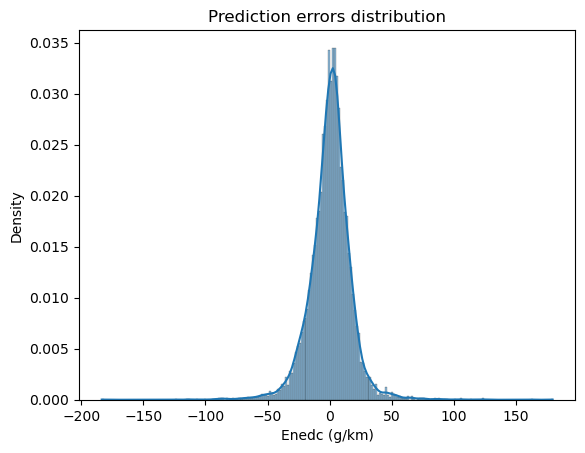

In [85]:
#Plot the error distribution
s = sns.histplot(error, stat='density', kde=True)
s.set_title('Prediction errors distribution');


We can see how the errors are distributed around the mean, though a bit skewed toward the positive side. Also, it is important to notice that while the distribution resembles a standard normal, it is actually very far from it, as tails are much fatter and the peak around the mean is much lower.

We then employ the Responsible AI dashboard from Microsoft to perform our error analysis. This dashboard takes an explainer model and creates error and counterfactual analysis in an easy to read format.

We start by defining our train and test dataset. For this analysis, we use a simple train/test split of 80/20 as we do not need to run the cross-validation anymore.

In [88]:
#Create test/train split and start the dashboard with our best model, and 100 test examples.

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_sample, y_sample, random_state=random_state, test_size=0.3)

train = X_train_e
test = X_test_e

train = train.astype(float)
test = test.astype(float)

train['Enedc'] = y_train_e
test['Enedc'] = y_test_e

rai_insights = RAIInsights(best_mlp, train, test[:100], 'Enedc', 'regression')

In [89]:
# Interpretability
rai_insights.explainer.add()
# Error Analysis
rai_insights.error_analysis.add()
# Counterfactuals: accepts total number of counterfactuals to generate, the range that their label should fall under, 
# and a list of strings of categorical feature names
rai_insights.counterfactual.add(total_CFs=20, desired_range=[0, 500])

In [90]:
#Compute the dashboard

rai_insights.compute()

100%|██████████| 100/100 [02:39<00:00,  1.59s/it]
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


In [91]:
#Launch the dashboard

ResponsibleAIDashboard(rai_insights)

ResponsibleAI started at http://localhost:5000


Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
Passing a set as an 

From the dashboard, we can get many insights on the errors of our model. More info to be found on the final report.

This concludes our analysis on the supervised learning part.